# Hydrological Flood‑Hour Classifier – **v3**  
*Generated 2025-08-06 22:55*

**Changes vs v2**
1. Flood label = station‑specific 92ᵗʰ percentile discharge.
2. Extra features: 1‑12 h discharge lags **and** 1‑ & 3‑hour discharge rate‑of‑change.
3. Model: **XGBoost** with `scale_pos_weight` to handle imbalance.
4. Threshold‑sweep table to pick desired recall vs precision.

Run all cells top‑to‑bottom inside VS Code. The notebook auto‑installs `xgboost` if missing.

In [1]:
# Auto‑install xgboost & imbalanced‑learn if they aren't present
import importlib, subprocess, sys, warnings, os
for pkg in ['xgboost', 'imbalanced-learn']:
    if importlib.util.find_spec(pkg) is None:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])


Installing imbalanced-learn...


In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [3]:
# ── CONFIG ────────────────────────────────────────────────────────────
PROJECT_ROOT = Path.cwd() if (Path.cwd() / 'data').exists() else Path.cwd().parent
DATA_RAW     = PROJECT_ROOT / 'data' / 'raw'
STATIONS     = ['D08A071', 'D08A084', 'D08A115']
ROLL_WINDOWS = [3, 6, 12]
LAG_HRS      = range(1, 13)          # 1‑12 h
PERCENTILE   = 0.92
TEST_FRAC    = 0.2
RANDOM_SEED  = 42
# ──────────────────────────────────────────────────────────────────────


In [4]:
def find_csv(code):
    folder = DATA_RAW / f'station_{code}'
    matches = list(folder.glob('*.csv'))
    assert len(matches)==1, f'{code}: not exactly one csv found'
    return matches[0]

def load_station(code):
    df = pd.read_csv(find_csv(code))
    df['datetime'] = pd.to_datetime(df['saatlik'])
    df = (df.rename(columns={'yagis_toplam':'rain_mm','qdeger':'discharge_cms'})
            .set_index('datetime')
            .sort_index()
            .resample('h')
            .agg({'rain_mm':'sum','discharge_cms':'mean'}) )
    df['station'] = code
    return df


In [5]:
# Load all stations
frames = [load_station(c) for c in STATIONS]
full   = pd.concat(frames, keys=STATIONS, names=['station','datetime'])
print('Shape:', full.shape)


Shape: (251649, 3)


In [6]:
# ── Feature engineering ───────────────────────────────────────────────
fe = full.copy()

# rainfall rolling sums
for w in ROLL_WINDOWS:
    fe[f'rain_sum_{w}h'] = (
        fe.groupby(level='station')['rain_mm']
          .rolling(w, min_periods=1).sum().values
    )

# discharge lags
for l in LAG_HRS:
    fe[f'dis_lag_{l}h'] = fe.groupby(level='station')['discharge_cms'].shift(l)

# discharge rate of change
fe['dis_rate_1h'] = fe.groupby(level='station')['discharge_cms'].diff(1)
fe['dis_rate_3h'] = fe.groupby(level='station')['discharge_cms'].diff(3)

fe = fe.dropna()
print('After FE:', fe.shape)


After FE: (79459, 20)


In [7]:
# ── Label floods ──────────────────────────────────────────────────────
thr = fe.groupby(level='station')['discharge_cms'].quantile(PERCENTILE)
fe['flood'] = (fe['discharge_cms'] >
               fe.index.get_level_values('station').map(thr)).astype(int)
print('Flood distribution:', fe['flood'].value_counts().to_dict())


Flood distribution: {0: 73384, 1: 6075}


In [8]:
# ── Train/test split ──────────────────────────────────────────────────
feature_cols = [c for c in fe.columns if c.startswith(('rain_','dis_lag','dis_rate'))]
X = fe[feature_cols]
y = fe['flood']

split = int(len(fe)*(1-TEST_FRAC))
X_train, y_train = X.iloc[:split], y.iloc[:split]
X_test,  y_test  = X.iloc[split:],  y.iloc[split:]

print('Train size', X_train.shape, 'Positives', y_train.sum())
print('Test  size', X_test.shape,  'Positives', y_test.sum())


Train size (63567, 18) Positives 4374
Test  size (15892, 18) Positives 1701


In [9]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║  Per-station XGBoost models (quick step-1 experiment)            ║
# ╚═══════════════════════════════════════════════════════════════════╝
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, average_precision_score
import pandas as pd, numpy as np

STATION_MODELS = {}
rows = []

for code in STATIONS:
    # ➊ slice one station (index level)
    df = fe.xs(code, level='station')
    X = df[feature_cols];  y = df['flood']
    
    # ➋ time-based split (same TEST_FRAC)
    split = int(len(df) * (1 - TEST_FRAC))
    X_tr, X_te = X.iloc[:split], X.iloc[split:]
    y_tr, y_te = y.iloc[:split], y.iloc[split:]

    neg, pos = np.bincount(y_tr)
    scale_pos = neg / pos
    
    # ➌ simple-but-strong XGB config
    clf = XGBClassifier(
        objective='binary:logistic',
        eval_metric='aucpr',
        learning_rate=0.05,
        n_estimators=800,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=scale_pos,
        n_jobs=-1,
    )
    clf.fit(X_tr, y_tr)
    STATION_MODELS[code] = clf   # save

    y_prob = clf.predict_proba(X_te)[:, 1]
    y_pred = (y_prob > 0.50).astype(int)

    rpt = classification_report(y_te, y_pred, output_dict=True)
    pr_auc = average_precision_score(y_te, y_prob)
    rows.append(
        {
            "station": code,
            "prec": round(rpt["1"]["precision"], 3),
            "rec":  round(rpt["1"]["recall"],    3),
            "f1":   round(rpt["1"]["f1-score"],  3),
            "PR-AUC": round(pr_auc, 3),
            "flood_hours": int(y_te.sum()),
        }
    )

pd.DataFrame(rows).set_index("station")

,prec,rec,f1,PR-AUC,flood_hours
station,,,,,
D08A071,0.99,1.000,0.995,1.000,497
D08A084,1.00,0.998,0.999,1.000,524
D08A115,1.00,0.941,0.970,0.997,17


In [10]:
# ── Fit XGBoost ───────────────────────────────────────────────────────
neg, pos = np.bincount(y_train)
scale_pos = neg / pos
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.05,
    n_estimators=550,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos,
    n_jobs=-1,
)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_pred = (y_prob > 0.5).astype(int)
min_len = 2
clean_pred = y_pred.copy()
run = 0
for i, val in enumerate(y_pred):
    if val == 1:
        run += 1
    else:
        if run < min_len:
            clean_pred[i-run:i] = 0   # wipe short spike
        run = 0

print(classification_report(y_test, y_pred, digits=3))
print('PR‑AUC:', average_precision_score(y_test, y_prob))


              precision    recall  f1-score   support

           0      1.000     0.867     0.929     14191
           1      0.473     0.999     0.642      1701

    accuracy                          0.881     15892
   macro avg      0.737     0.933     0.785     15892
weighted avg      0.944     0.881     0.898     15892

PR‑AUC: 0.9210372634422967


In [16]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)

# basic point-metrics at your chosen threshold (0.005 here)
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
cm   = confusion_matrix(y_test, y_pred)

print(f"Accuracy        : {acc:0.3f}")
print(f"Precision (pos) : {prec:0.3f}")
print(f"Recall    (pos) : {rec:0.3f}")
print("Confusion matrix:\n", cm)

Accuracy        : 0.881
Precision (pos) : 0.473
Recall    (pos) : 0.999
Confusion matrix:
 [[12299  1892]
 [    1  1700]]


In [12]:
# ── Threshold sweep table ─────────────────────────────────────────────
prec, rec, thr = precision_recall_curve(y_test, y_prob)
rows = []
for p,r,t in zip(prec, rec, thr):
    rows.append({'thr': round(t,10), 'precision': round(p,3), 'recall': round(r,3)})
sweep = pd.DataFrame(rows)
print(sweep[sweep['recall']>=0.80].head(15))


         thr  precision  recall
0   0.000001      0.107     1.0
1   0.000008      0.107     1.0
2   0.000009      0.107     1.0
3   0.000009      0.107     1.0
4   0.000009      0.107     1.0
5   0.000010      0.107     1.0
6   0.000011      0.107     1.0
7   0.000012      0.107     1.0
8   0.000013      0.107     1.0
9   0.000014      0.107     1.0
10  0.000014      0.107     1.0
11  0.000014      0.107     1.0
12  0.000014      0.107     1.0
13  0.000015      0.107     1.0
14  0.000016      0.107     1.0


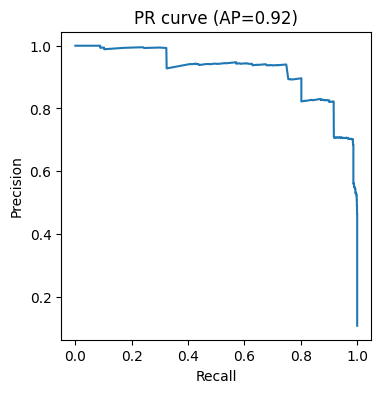

In [13]:
# ── Optional PR curve ────────────────────────────────────────────────
plt.figure(figsize=(4,4))
plt.plot(rec, prec)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('PR curve (AP={:.2f})'.format(average_precision_score(y_test, y_prob)))
plt.show()
